# Final

In this last section I will list my top four models and their respective performances on a validation set. However, only for my final model I will explain how the fitting procedure works in detail.

In particular I consider a

1. Linear model using a subset of features
2. Deep neural network with dropout regularization
3. Two-stage random forest with feature selection
4. Gradient tree boosting (*the final model*)

If you only care about the final model please jump directly to subsection 4, in which I explain how the model is fit on a theoretical basis as well as the (Python) implementation. Note also that in the very last subsection I include a table comparing the validation mean squared error for all of the presented models.

## Preliminaries

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

ROOT = Path(os.getcwd()).parent
np.random.seed(0)

In [2]:
df_train = pd.read_parquet(ROOT / "bld" / "train_simulated.parquet")
df_val = pd.read_parquet(ROOT / "bld" / "validate_simulated.parquet")

y_train = df_train["Y"]
X_train = df_train.drop("Y", axis=1)

y_val = df_val["Y"]
X_val = df_val.drop("Y", axis=1)

## 1. Linear Model Using a Subset of Features

Here I fit a simple "two-step" 3rd degree polynomial regression model to benchmark the machine learning methods from below. The procedure has two steps as I only consider the features $\{X_3, X_{12}, X_{38}\}$. This set of features was selected in the previous section using the recursive feature elimination strategy. However, basically all other feature selection strategies considered in the previous section selected a similar set of features.

In [3]:
relevant = [f"X{k}" for k in [3, 12, 38]]

XX_train = X_train[relevant]
XX_val = X_val[relevant]

poly = PolynomialFeatures(degree=3, include_bias=False)
XX_train = poly.fit_transform(XX_train)
XX_val = poly.transform(XX_val)

lm = LinearRegression(n_jobs=3)
lm.fit(XX_train, y_train)

prediction = lm.predict(XX_val)
mse_lm = mean_squared_error(y_val, prediction)
print(f"(Linear Model) MSE: {mse_lm}")

(Linear Model) MSE: 5.361621926612066


## 2. Deep Neural Network with Dropout Regularization

I fit a deep neural network using the popular [keras](https://keras.io/) library ({cite}`keras`) which provides an intuitive API for the powerful [tensorflow](https://www.tensorflow.org/) package ({cite}`tensorflow`). The neural network architecture is set using the ``build_regressor`` function. I choose an archtecture with 7 layers. For the first layer I choose 50 hidden nodes, 25 hidden nodes for the second layer and 10 hidden nodes for the third to seventh layer. Moreover I use the so called [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function, which has been proven to outperform the classic sigmoid activation function in several ways, see for example {cite}`krizhevsky2017`. As overfitting is a big problem with deep networks I employ a popular technique called dropout regularization to mitigate this effect, see {cite}`srivastava2014`. Dropout leads to neurons in a layer being randomly deactivated for a single epoch during the backpropagation, which in turn leads to neighboring neurons not developing a relationship that is too strongly dependent, which in turn is said to mitigate overfitting.

***Note.***

I decide to use this specific architecture as I "learned" from the previous section that the main effects are sparse in the sense that only very few features are relevant. However, I also realized from playing around with some parameters and the validation error of the linear model that some effects must be highly non-linear. An architecture which reduces the nodes from the original 100 input dimensions to 50, then 25 and then 10 forces the network to select the relevant features. And by using the other additional 5 layers the network can find non-linear signals.

***Remark.***

Since the gradient boosted tree presented below performs so well I did not consider many different architectures. I do believe that the neural networks should be able to perform comparably well if a different architecture is chosen.

In [4]:
N_COL = X_train.shape[1]
def build_regressor():
    regressor = Sequential()
    # first hidden layer
    regressor.add(Dense(units=50, activation="relu", input_dim=N_COL))
    regressor.add(Dropout(0.2))
    
    # second hidden layer
    regressor.add(Dense(units=25, activation="relu"))
    regressor.add(Dropout(0.2))
    
    # third to tenth hidden layer
    for _ in range(5):
        regressor.add(Dense(units=10, activation="relu"))
    
    # output layer
    regressor.add(Dense(units=1, activation="linear"))
    
    # compile model
    regressor.compile(optimizer="adam", loss="mean_squared_error")
    return regressor

In [5]:
nnet = KerasRegressor(
    build_fn=build_regressor, batch_size=128, epochs=200, verbose=0
)
nnet.fit(X_train, y_train)

prediction = nnet.predict(X_val)
mse_nnet = mean_squared_error(y_val, prediction)
print(f"(Neural Network) MSE: {mse_nnet}")

(Neural Network) MSE: 5.270290083073366


## 3. Two-stage Random Forest with Feature Selection

In this two stage procedure I first fit a random forest on the full set of features. I then consider a feature importance measure, which can be automatically calculated from the random forest fit. Using this I select the 30 *most* important features and fit another random forest on this subset of features.

***First Stage***

In [6]:
rf = RandomForestRegressor(
    n_estimators=250, 
    max_features=25, 
    max_depth=15,
    min_samples_leaf=100,
    bootstrap=True,
    n_jobs=3,
    random_state=1,
)
rf.fit(X_train, y_train.values)

std = np.std(
    [tree.feature_importances_ for tree in rf.estimators_], 
    axis=0
)
indices = np.argsort(rf.feature_importances_)[::-1]
relevant = [f"X{i+1}" for i in indices[:30]]

prediction = rf.predict(X_val)
mse_first_stage = mean_squared_error(y_val, prediction)
print(f"First stage MSE: {mse_first_stage}")

First stage MSE: 5.1615609346407565


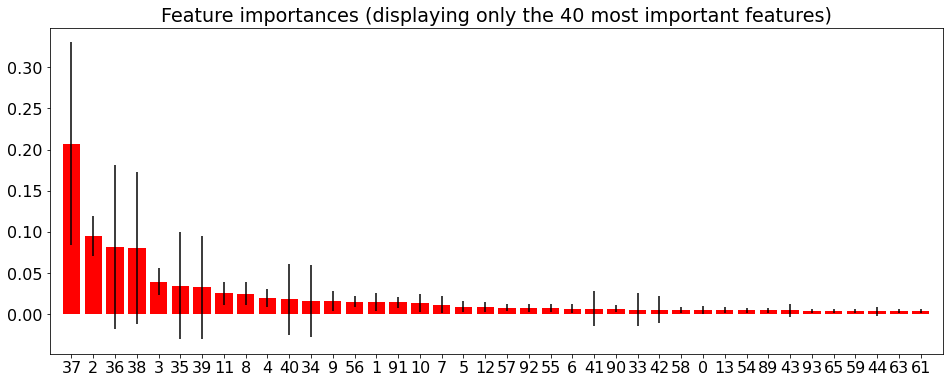

In [7]:
# plotting code: can be safely ignored
plt.rcParams.update({'font.size': 16, 'figure.figsize': (16, 6)})
cut = 40
x = range(X_train.shape[1])[:cut]
y = rf.feature_importances_[indices][:cut]
plt.figure()
plt.title(f"Feature importances (displaying only the {cut} most important features)")
plt.bar(x, y, color="r", yerr=std[indices][:cut], align="center")
plt.xticks(x, indices[:cut])
plt.xlim([-1, cut])
plt.show()

***Second Stage***

In [8]:
XX_train = X_train[relevant]
XX_val = X_val[relevant]

rf = RandomForestRegressor(
    n_estimators=250, 
    max_features=15, 
    max_depth=15,
    min_samples_leaf=100,
    bootstrap=True,
    n_jobs=3,
    random_state=1,
)
rf.fit(XX_train, y_train.values)

prediction = rf.predict(XX_val)
mse_rf = mean_squared_error(y_val, prediction)
print(f"(Random Forest) MSE: {mse_rf}")

(Random Forest) MSE: 5.120511556417796


## 4. Gradient tree boosting (*the final model*)

The final model I am using is a specific variant of a gradient boosted tree. The key concepts of the method are equivalent to the seminal paper by Friedman, see {cite}`friedman2002`. I use the version implemented in the [catboost](https://catboost.ai/) package, which differs slightly from common implementations. Next I will introduce the concept of gradient boosting with a particular focus on tree weak-learners. Afterwards I show how to fit a model using ``catboost``. Note that my final prediction submissions are not made with this specific model since here I only use my training sample. The final predictions are made with the script [final_prediction.py](https://github.com/timmens/topics-project/blob/main/codes/final_prediction.py).


### Theory

Write about the theory of Catboost HERERERE!!!


### Implementation / Application

In [9]:
gbt = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.01, 
    depth=5,
    loss_function="RMSE",
    random_state=1
)
gbt.fit(X_train, y_train, verbose=False)

prediction = gbt.predict(X_val)
mse_gbt = mean_squared_error(y_val, prediction)
print(f"(Catboost) MSE: {mse_gbt}")

(Catboost) MSE: 5.048105271497743


## MSE Comparison

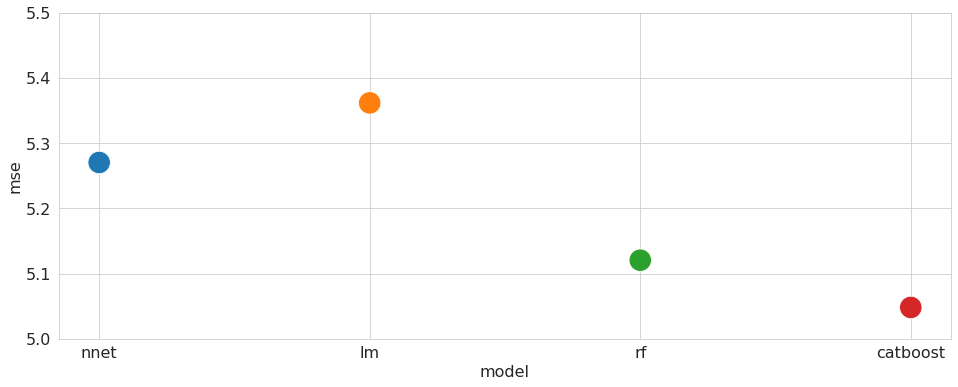

In [10]:
models = ["nnet", "lm", "rf", "catboost"]
mses = [mse_nnet, mse_lm, mse_rf, mse_gbt]
data = pd.DataFrame(zip(models, mses), columns=["model", "mse"])

sns.set_style("whitegrid")
plt.ylim(5, 5.5)
_ = sns.scatterplot(
    x="model", y="mse", data=data, hue="model", s=500, legend=None
)